## Import Python libary

In [4]:
import librosa
import numpy as np
import pandas as pd
import webrtcvad
import os
import re
import math
import matplotlib.pyplot as plt

## Global variables

In [5]:
Speakers = ['Emily', 'Ethan', 'Olivia', 'Liam', 'Sophia', 'Jackson', 'Ava', 'Aiden', 'Emma', 'Noah', 'Isabella', 
            'Lucas', 'Mia', 'Mason', 'Harper', 'Elijah', 'Abigail', 'Logan', 'Grace', 'Benjamin']
NumOfSpeakers = 20
NumOfDataOfSpeaker = [] #儲存每個speaker的音檔數量
AudioFiles = []  #包含所有的音檔：[[(y, sr), (y, sr)......], [], []......]
DataFrame = pd.DataFrame()  #包含所有音檔的DataFrame
training_y = pd.DataFrame()
training_X = pd.DataFrame()
validation_y = pd.DataFrame()
validation_X = pd.DataFrame()


## Read files

In [6]:
def ReadFile(AudioFiles, NumOfDataOfSpeaker):
    base_path = 'dataset'
    for actor_id in os.listdir(base_path):
        actor_path = os.path.join(base_path, actor_id)     #actor_path = dataset/id
        tmp = []
        cnt = 0

        for book_id in os.listdir(actor_path):
            book_path = os.path.join(actor_path, book_id)  #book_path = dataset/id/number
            
            for file_name in os.listdir(book_path):
                if file_name.endswith('.flac'):
                    file_path = os.path.join(book_path, file_name)  #file_path = dataset/id/number/file_name

                    # 判斷音檔長度，大於10秒才保留
                    duration = librosa.get_duration(path=file_path)
                    if duration < 10: continue
                    
                    # 使用librosa加載音頻
                    y, sr = librosa.load(file_path, sr=None)
                    y = y[:int(sr * 10)]  #把超過10秒的部分剪掉
                    tmp.append((y, sr))
                    cnt += 1
        NumOfDataOfSpeaker.append(cnt)
        AudioFiles.append(tmp)

ReadFile(AudioFiles, NumOfDataOfSpeaker)

## VAD and Noise reduction

In [7]:
def VAD():
    pass

def NoiseReduction():
    pass

## Extract Features

##### Melspectrograms

In [8]:
def Melspectrogram(y, sr):
    # 計算梅爾頻譜圖
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # 將梅爾頻譜圖轉換為分貝表示
    log_melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    return log_melspectrogram

##### MFCC coefficient

In [9]:
def MFCC(y, sr):
    # 提取MFCC参数
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    return mfcc

## Build DataFrame

In [10]:
def BuildDataFrame():
    DataFrame = pd.DataFrame(columns=['Melspectrogram', 'MFCC', 'Speaker']) 
    for i in range(NumOfSpeakers):
        for audio_file in AudioFiles[i]:
            data = pd.DataFrame({
                'Melspectrogram': [Melspectrogram(audio_file[0], audio_file[1])], 
                'MFCC': [MFCC(audio_file[0], audio_file[1])], 
                'Speaker': Speakers[i]
            })
            DataFrame = pd.concat([DataFrame, data], ignore_index=True)
    return DataFrame

DataFrame = BuildDataFrame()

In [11]:
DataFrame[:3]

,Melspectrogram,MFCC,Speaker
0,"[[-40.79799, -43.72983, -43.54191, -41.7604, -...","[[-496.41382, -488.91962, -495.58084, -495.352...",Emily
1,"[[-36.541676, -38.338985, -40.55909, -40.10146...","[[-366.32916, -360.35193, -398.2274, -442.2688...",Emily
2,"[[-40.195602, -44.715412, -44.12776, -44.93044...","[[-388.48203, -367.78357, -379.08673, -408.614...",Emily


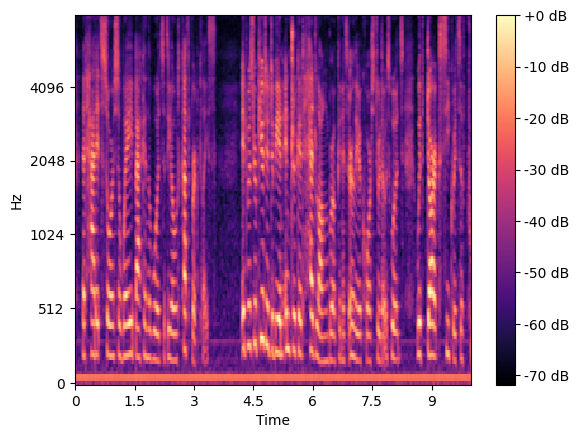

In [12]:
# 顯示梅爾頻譜圖
librosa.display.specshow(DataFrame.at[1, 'Melspectrogram'], sr=AudioFiles[0][1][1], x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Split data

In [13]:
def Split_training_and_validation(y, X):
    training_y = pd.DataFrame() 
    training_X = pd.DataFrame()
    validation_y = pd.DataFrame()
    validation_X = pd.DataFrame()
    index = 0
    for i in range(NumOfSpeakers):
        split_size = math.floor(NumOfDataOfSpeaker[i] * 0.8)
        training_y = pd.concat([training_y, y[index:index + split_size]], ignore_index=True) 
        validation_y = pd.concat([validation_y, y[index + split_size:index + NumOfDataOfSpeaker[i]]], ignore_index=True)
        training_X = pd.concat([training_X, X[index:index + split_size]], ignore_index=True)
        validation_X = pd.concat([validation_X, X[index + split_size:index + NumOfDataOfSpeaker[i]]], ignore_index=True)
        index += NumOfDataOfSpeaker[i]
    return training_y, training_X, validation_y, validation_X
        
def SplitData(DataFrame):
    y = DataFrame['Speaker']
    X = DataFrame.drop('Speaker', axis=1)
    return Split_training_and_validation(y, X)

training_y, training_X, validation_y, validation_X = SplitData(DataFrame)

Words counts

In [ ]:
target_words = ["ZERO", "ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX", "EIGHT", "NINE", "TEN"]
dataset_root = 'testest-code'
word_counts = {word: 0 for word in target_words}

actorNums = 0
chapterNums = 0
for actor_folder in os.listdir(dataset_root):
    actor_path = os.path.join(dataset_root, actor_folder)
    
    if os.path.isdir(actor_path):

        actorNums += 1
        # print(f'Actor Folder: {actor_folder}')
        
        for script_folder in os.listdir(actor_path):
            script_path = os.path.join(actor_path, script_folder)
            
            if os.path.isdir(script_path):
                trans_file = os.path.join(script_path, f'{actor_folder}-{script_folder}.trans.txt')
                
                if os.path.exists(trans_file):
                    chapterNums += 1
                    with open(trans_file, 'r', encoding='utf-8') as f:
                        script_text = f.read()
                    
                    for word in target_words:
                        word_counts[word] += len(re.findall(r'\b' + word + r'\b', script_text, re.IGNORECASE))


print(str(dataset_root))
print('Total actors   : ' + str(actorNums))
print('Total chapters : ' + str(chapterNums))
for word, count in word_counts.items():
    print(f'{word:{6}}: {count}')